In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
plt.style.use("ggplot")

In [2]:
with open("NKJP_org.csv") as f:
    text= f.read()
sentences = text.split("\n\n")
split_sentences = [sentence.split("\n") for sentence in sentences if any(sentence)]


In [3]:
grouped_sentences = []
for sentence in split_sentences:
    s = []
    for word in sentence:
        s.append(word.split("\t"))
    grouped_sentences.append(s)
    
for sentence in grouped_sentences:
    for word in sentence:
        if len(word) == 2:
            word.extend(["O", "O"])
        if len(word) == 3:
            word.insert(2, 'O')

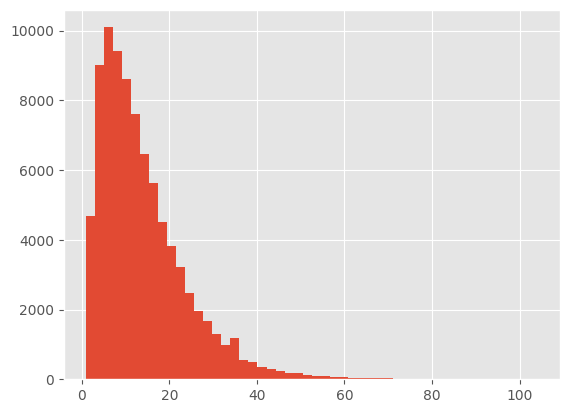

In [4]:
%matplotlib inline
plt.hist([len(sen) for sen in grouped_sentences], bins= 50)
plt.show()

In [5]:
biggest_len = max([len(s) for s in grouped_sentences])
biggest_len

104

In [6]:
max_len = 55

In [7]:
data = []
all_labels = []
all_tokens = ['<PAD>']
for sentences in grouped_sentences:
    if len(sentences) <= max_len:
        tokens = [sentence[0] for sentence in sentences]
        labels = [sentence[3] for sentence in sentences]
        assert len(tokens) <= max_len
        pads_number_to_extend = max_len-len(tokens)
        tokens.extend(['<PAD>'] * pads_number_to_extend)
        labels.extend(['O'] * pads_number_to_extend)
        assert len(tokens) == max_len
        assert len(labels) == max_len
        data.append({'tokens': tokens, "labels": labels})
        all_tokens.extend(tokens)
        all_labels.extend(labels)

In [8]:
tokens_number = len(set(all_tokens))
labels_number = len(set(all_labels))
tokens_number, labels_number

(140583, 15)

In [9]:
set(all_labels)

{'O',
 'addName',
 'bloc',
 'country',
 'date',
 'district',
 'forename',
 'geogName',
 'orgName',
 'persName',
 'placeName',
 'region',
 'settlement',
 'surname',
 'time'}

In [10]:
words2index = {w:i for i,w in enumerate(list(set(all_tokens)))}
tags2index = {t:i for i,t in enumerate(list(set(all_labels)))}
index2words = {i:w for i,w in enumerate(list(set(all_tokens)))}
index2tags = {i:t for i,t in enumerate(list(set(all_labels)))}

In [11]:
print(words2index['Liceum'])
print(tags2index['geogName'])

111786
5


In [12]:
data[0]

{'tokens': ['Bohaterem',
  'powieści',
  'Paźniewskiego',
  'jest',
  'miasto',
  ',',
  'Krzemieniec',
  '.',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>'],
 'labels': ['O',
  'O',
  'surname',
  'O',
  'O',
  'O',
  'settlement',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '

In [13]:
x = [[words2index[w] for w in sentence['tokens']] for sentence in data]
y = [[tags2index[w] for w in sentence['labels']] for sentence in data]

In [14]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_tr, X_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=1)

In [15]:
batch_size = 512
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
sess = tf.Session()
K.set_session(sess)

2023-01-15 23:04:52.642166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


2023-01-15 23:04:57.079793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
import keras
from keras.models import Model
from tensorflow.keras.layers import Input, add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [17]:
X_tr, X_val = np.array(X_tr[:1213*batch_size]), np.array(X_tr[-135*batch_size:])
y_tr, y_val = np.array(y_tr[:1213*batch_size]), np.array(np.array(y_tr[-135*batch_size:]))


In [18]:
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [19]:
y_tr[0]

array([[6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [9],
       [6],
       [6],
       [6],
       [6],
       [9],
       [4],
       [2],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6],
       [6]])

In [20]:
X_tr.shape

(68172, 55)

In [21]:
assert len(X_tr) == len(y_tr)
assert len(X_val) == len(y_val)

In [22]:
input_text = Input(shape=(55,))
embedding = Embedding(
        input_dim=tokens_number+1,
        input_length=max_len,
        output_dim=20,
        mask_zero=True
       )(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
_x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(labels_number, activation="softmax"))(_x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
out

<tf.Tensor 'time_distributed/Reshape_1:0' shape=(?, 55, 15) dtype=float32>

In [24]:
def custom_sparse_categorical_accuracy(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)

    return K.cast(K.equal(K.max(y_true, axis=-1),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
                  K.floatx())

In [25]:
model = Model(input_text, out)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [26]:
history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 68172 samples, validate on 68172 samples


2023-01-15 23:05:01.451907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-01-15 23:05:01.532879: W tensorflow/c/c_api.cc:291] Operation '{name:'training/RMSprop/bidirectional_1/forward_lstm_1/lstm_cell_4/kernel/rms/Assign' id:5090 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/bidirectional_1/forward_lstm_1/lstm_cell_4/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/bidirectional_1/forward_lstm_1/lstm_cell_4/kernel/rms, training/RMSprop/bidirectional_1/forward_lstm_1/lstm_cell_4/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/3
63488/68172 [==========================>...] - ETA: 1:31 - loss: 0.2579 - acc: 0.9782

KeyboardInterrupt: 

In [ ]:
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)